## Import dependencies

In [2]:
from calendar import monthrange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder

rng = np.random.RandomState(0)

## Load data frame

In [ ]:
# ToDo: Custom column import with specified data types and additional na values
# => see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
df = pd.read_excel("data/Vehicles_export_prices_scaled_train_eng.xlsx")
df.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,...,CUSTOMER_SALE_GROUP_NAME,CUSTOMER_SALE_GROUP2,CUSTOMER_SALE_GROUP2_NAME,SCALED_CURRENT_VALUE,SCALED_INVENTURAL_VALUE,SCALED_REPORT_VALUE,SCALED_VALUATION_PRICE,SCALED_GUIDE_PRICE,SCALED_TOTAL_SALES_PRICE_BASIS,SCALED_TOTAL_SALE_PRICE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,NaN,...,EV privat,EVPR,Endverbraucher private,0.052907,0.000000,0.950043,0.0,0.002975,0.011018,0.011321
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,...,NaN,NaN,NaN,0.061605,0.000000,0.950043,0.0,0.006136,0.026411,0.019844
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,...,EV privat,EVPR,Endverbraucher private,0.063286,0.000000,0.950043,0.0,0.001378,0.022102,0.022053
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,...,Interne Kunden,INT,Interne Kunden,0.042565,0.029537,0.897257,0.0,0.001378,0.000000,0.000572
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,...,NaN,NaN,NaN,0.054914,0.000000,0.950043,0.0,0.004863,0.019715,0.013360


## Clean data frame

### Manual feature selection

In [4]:
columns_of_interest = [
    # "RPAKREP_VEHICLE_HKEY", # id of each sample
    "COMPANY",
    "OFFICE",
    # "OFFICE_MAIN_BRAND", # could be used for an additional feature (comparison to MANUFACTURER_SHORT)
    # "CHASSIS_NUMBER", # irrelevant as it is a unique identifier for the vehicle
    "MANUFACTURER_SHORT",
    # "MANUFACTURER", # contains more null values then MANUFACTURER_SHORT
    "VEHICLE_GROUP",
    # "VEHICLE_TYPE", # contains too many unique entries (>13,700)
    # "MODEL_CODE", # contains many null values and too many unique ones
    # "VARIANT", # mostly null values
    "MILEAGE",
    # "OPERATING_HOURS", # contains just 6 unique values, mostly 0s
    # "MILAGE_IN_FIELD", # contains just 1s and nulls, mostly 1s
    "MILAGE_SALES", # the difference between MILEAGE and MILAGE_SALES might be more relevant
    # "OPERATING_HOURS_SALES", # contains just 5 unique values, mostly 0s
    # "RIM_KEY", # contains mostly nulls
    # "COLOR_CODE", # contains only 30% not nulls
    # "COLOR_CODE_NAME", # contains mostly 'Nicht definiert'
    "COLOR",
    # "COLOR_TYPE", # contains mostly 'N'
    # "UPHOLSTERY_CODE", # contains only 30% not nulls
    "UPHOLSTERY",
    # "UPHOLSTERY_CODE_ALT", # contains mostly 'N'
    # "CERTIFICATE_TYPE", # mostly nulls
    # "CERTIFICATE_TYPE_DATE", # mostly 0s
    # "FACTORY_NUMBER", # mostly nulls
    # "ENGINE_ID", # many nulls, more like an id
    "ENGINE_TYPE",
    # "ENGINE_ID_ALT", # 60% nulls
    # "TRANSMISSION", # 80% nulls
    "TRANSMISSION_TYPE",
    # "TRANSMISSION_ID", # 80% nulls
    # "TRANSMISSION_SHORT", # mostly mappable to TRANSMISSION_NAME
    "TRANSMISSION_NAME",
    # "RIMS", # mostly nulls
    # "FRONT_TIRES", # mostly nulls
    # "FRONT_TIRES_CONDITION", # mostly 0.00
    # "REAR_TIRES", # mostly nulls
    # "REAR_TIRES_CONDITION", # mostly 0.00
    "NUMBER_DOORS",
    "NUMBER_SEATS",
    # "PERMITTED_TOTAL_WEIGHT", # 85% 0s
    # "MAX_TRAILOR_LOAD", # 95% 0s
    "CURB_WEIGHT",
    "YEAR_CONSTRUCTION",
    # "CONSTRUCTION_MONTH", # might not be relevant
    # "NUMBER_AXLE", # mostly 0s
    "NUMBER_ENGINE_CYLINDER",
    # "REPAIR_RKZ", # only 0s and nulls
    # "OPTICAL_CONDITION", # only 0s and nulls
    # "TECHNICAL_CONDITION", # only 0s and nulls
    "ACCIDENT_VEHICLE",
    # "COMMISSION_NUMBER", # too many uniques
    "HORSEPOWER",
    # "KW", # horsepower egould be enough
    "CCM",
    "NUMBER_OWNERS",
    # "IS_USED_CAR", # can be mapped from NUMBER_OWNERS
    # "LEASING_CONTRACT_DATE", # mostly nulls
    # "LEASING_START", # mostly nulls
    # "LEASING_END", # mostly nulls
    # "LEASING_MILAGE", # mostly 0s
    # "PAINT_TYPE", # only nulls
    # "FINANCING_TYPE", # FINANCING_TYPE_NAME is already enough
    "FINANCING_TYPE_NAME",
    # "KAT_VEHICLE", # one class is overrepresented
    # "FUEL_TYPE", # FUEL_TYPE_NAME is already enough
    "FUEL_TYPE_NAME",
    # "DRIVE_TYPE", # DRIVE_TYPE_NAME is already enough
    "DRIVE_TYPE_NAME",
    # "VEHICLE_MODEL_ID", # VEHICLE_MODEL_ID_NAME is already enough
    "VEHICLE_MODEL_ID_NAME",
    # "COMMISSION_TYPE", # COMMISSION_TYPE_NAME is already enough
    "COMMISSION_TYPE_NAME",
    # "DEMONSTRATION_STATUS", # mostly nulls
    "PURCHASE_DATE",
    # "PURCHASE_BOOKING_DATE", # not relevant due to PURCHASE_DATE
    # "PURCHASE_MILAGE", # the difference between PURCHASE_MILAGE and MILAGE_SALES might be more relevant
    # "PURCHASE_OPERATION_HOURS", # only 0s and nulls
    # "PRICE_LIST", # mostly nulls
    # "DAY_OF_REGISTRATION", # mostly nulls and 'N'
    # "AT_LOCATION_SINCE", # mostly 0s
    "LAID_UP_TIME",
    # "SOLD_CUSTOMER_ID", # too many different classes
    # "SOLD_INVOICE_COSTUMER_ID", # too many different classes
    # "MILAGE_SALE", # mostly identical to MILAGE_SALES
    # "OPERATION_HOURS_SALE", mostly 0s
    # "SOLD_INVOICE_COSTUMER_ID2", # too many different classes
    "CUSTOMER_TYPE",
    # "CUSTOMER_GROUP", # CUSTOMER_SALE_GROUP2_NAME is already enough
    # "CUSTOMER_GROUP_NAME", # CUSTOMER_SALE_GROUP2_NAME is already enough
    # "CUSTOMER_FEATURE", # CUSTOMER_SALE_GROUP2_NAME is already enough
    # "CUSTOMER_FEATURE_NAME", # CUSTOMER_SALE_GROUP2_NAME is already enough
    # "SALE_CUSTOMER_ID2", # too many different classes
    # "CUSTOMER_SALE_GROUP", # CUSTOMER_SALE_GROUP2_NAME is already enough
    # "CUSTOMER_SALE_GROUP_NAME", # CUSTOMER_SALE_GROUP2_NAME is already enough
    # "CUSTOMER_SALE_GROUP2", # CUSTOMER_SALE_GROUP2_NAME is already enough
    "CUSTOMER_SALE_GROUP2_NAME",
    "SCALED_CURRENT_VALUE",
    "SCALED_INVENTURAL_VALUE",
    "SCALED_REPORT_VALUE",
    # "SCALED_VALUATION_PRICE", # only contains 0.00
    "SCALED_GUIDE_PRICE",
    "SCALED_TOTAL_SALES_PRICE_BASIS",
    "SCALED_TOTAL_SALE_PRICE"
]

print(f"before: {len(df.columns)} features")

df_cleaned = df[columns_of_interest]

print(f"after: {len(df_cleaned.columns)} features")

before: 106 features
after: 35 features


### Remove rows with to many nulls

In [5]:
print(f"before: {len(df_cleaned)} samples")

max_nulls = 3
df_cleaned = df_cleaned.dropna(thresh=len(df_cleaned.columns) - max_nulls)

print(f"after: {len(df_cleaned)} samples")

before: 99071 samples
after: 91240 samples


## Split data frame into features and labels

In [6]:
# Features
X = df_cleaned.drop("LAID_UP_TIME", axis=1)

# Labels
y = df_cleaned["LAID_UP_TIME"]

## Split test and train set

mean: 89.21177663305568
std: 105.61362706949886


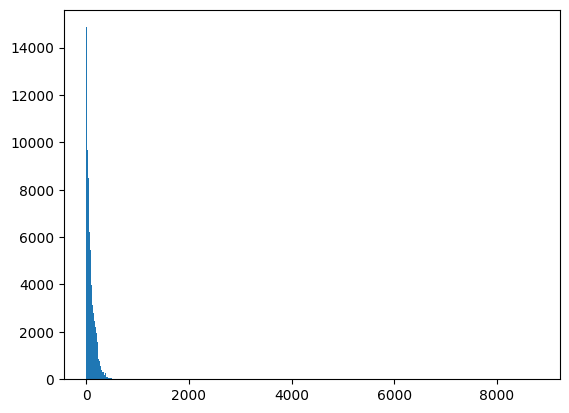

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

print(f"mean: {np.mean(y_train)}")
print(f"std: {np.std(y_train)}")
plt.hist(y_train, bins=512)
plt.show()

## Preprocessing

In [8]:
def to_number(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.astype("float64")


def to_category(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.astype("string")


def map_date(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.astype("datetime64[ns]").map(lambda date: date_to_number(date))


def date_to_number(date: np.datetime64) -> np.float64:
    if date is pd.NaT:
        return np.nan
    return date.year + date.month / 12.0 + date.day / (12.0 * monthrange(date.year, date.month)[1])


num_features = [
    "MILEAGE",
    "MILAGE_SALES",
    "NUMBER_DOORS",
    "NUMBER_SEATS",
    "CURB_WEIGHT",
    "YEAR_CONSTRUCTION",
    "NUMBER_ENGINE_CYLINDER",
    "HORSEPOWER",
    "CCM",
    "NUMBER_OWNERS",
    "SCALED_CURRENT_VALUE",
    "SCALED_INVENTURAL_VALUE",
    "SCALED_REPORT_VALUE",
    "SCALED_GUIDE_PRICE",
    "SCALED_TOTAL_SALES_PRICE_BASIS",
    "SCALED_TOTAL_SALE_PRICE",
]
num_transformer = Pipeline([
    ("converter", FunctionTransformer(to_number)),
    ("imputer", SimpleImputer()),
    ("scaler", RobustScaler()),
])

cat_features = [
    "COMPANY",
    "OFFICE",
    "MANUFACTURER_SHORT",
    "VEHICLE_GROUP",
    "COLOR",
    "UPHOLSTERY",
    "ENGINE_TYPE",
    "TRANSMISSION_TYPE",
    "TRANSMISSION_NAME",
    "ACCIDENT_VEHICLE",
    "FINANCING_TYPE_NAME",
    "FUEL_TYPE_NAME",
    "DRIVE_TYPE_NAME",
    "VEHICLE_MODEL_ID_NAME",
    "COMMISSION_TYPE_NAME",
    "CUSTOMER_TYPE",
    "CUSTOMER_SALE_GROUP2_NAME",
]
cat_transformer = Pipeline([
    ("converter", FunctionTransformer(to_category)),
    ("imputer", SimpleImputer(missing_values=pd.NA, strategy="most_frequent")),
    ("encoder", OneHotEncoder(min_frequency=0.05, handle_unknown="infrequent_if_exist", sparse_output=False)),
    ("selector", SelectPercentile(chi2, percentile=50)),
])

date_features = [
    "PURCHASE_DATE"
]
date_transformer = Pipeline([
    ("converter", FunctionTransformer(map_date)),
    ("imputer", SimpleImputer()),
    ("scaler", RobustScaler()),
])

preprocessor = Pipeline([
    ("per_feature", ColumnTransformer([
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
        ("date", date_transformer, date_features),
    ], verbose_feature_names_out=False)),
    ("selector", SelectKBest(f_regression, k=10))
])
# preprocessor.set_output(transform="pandas")

# foo: pd.DataFrame = preprocessor.fit_transform(X_train, y_train)
# foo["LAID_UP_TIME"] = y_train
# corr_matrix = foo.corr()
# corr_matrix["LAID_UP_TIME"].sort_values(ascending=False)

## Model selection

In [9]:
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")

RMSE: 75.09299394621944


Next steps:
- read-excel-function
- per feature mapping (to nulls, etc.)
- Cross validation
- Other models